<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: group visiha
# Student 1: Sidney Damen
# Student 2: Haoqi Guo
# Student 3: Victor Wen

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# Change the following  line to the directory this notebook is (if using colab)
# In case you do not know the path, open the file navigator on the left in colab
# Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir) 
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


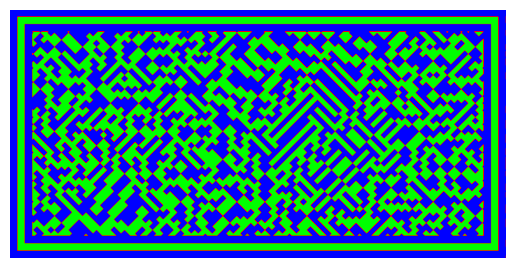

In [6]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
batch_size = 32
image_size = 96*60
num_classes = y_train.shape[1]

In [8]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
# Train model
def train(model, train_loader, val_loader, optimizer, criterion, n_epochs=10, device='cpu'):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pred = y_hat.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(y.argmax(dim=1, keepdim=True)).sum().item()
        train_acc = train_correct/len(train_loader.dataset)
        train_loss /= len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
          for X, y in val_loader:
              X, y = X.to(device), y.to(device)
              y_hat = model(X)
              loss = criterion(y_hat, y)
              val_loss += loss.item()
              pred = y_hat.argmax(dim=1, keepdim=True)
              val_correct += pred.eq(y.argmax(dim=1, keepdim=True)).sum().item()
        val_acc = val_correct/len(val_loader.dataset)
        val_loss /= len(val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        
        print(f'Epoch {epoch+1}/{n_epochs}: Train loss: {train_loss:.4f}, Train acc: {train_acc*100:.2f}, Val loss: {val_loss:.4f}, Val acc: {val_acc*100:.2f}')
    return train_losses, train_accuracies, val_losses, val_accuracies

# Test model
def test(model, test_loader, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            test_loss += F.cross_entropy(y_hat, y, reduction='sum').item()
            pred = y_hat.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.argmax(dim=1, keepdim=True)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset)*100:.2f}%)')

In [10]:
class Lambda(nn.Module):
  def __init__(self, func):
      super().__init__()
      self.func = func

  def forward(self, x):
      return self.func(x)

model = nn.Sequential(
    
    #block 1

    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    #block 2

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 32, 4, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 3

    sc.Slice(rotation=1, reflection=False),
    sc.SymmetryConv2d(32, 64, 3, stride=1, rotation=1, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 4

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 128, 8, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 5

    Lambda(lambda x: x.view(x.size(0),-1)),
    nn.Linear(2688 , 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes),
    nn.Softmax(dim=1)

)      

In [11]:
import pandas as pd

def plot_learning_curves(train_loss, train_accuracies, val_losses, val_accuracies):
    # Plot the losses and accuracies
    learning_curves = pd.DataFrame({'Train loss': train_losses, 'Train accuracy': train_accuracies, 'Validation loss': val_losses, 'Validation accuracy': val_accuracies})

    print("Max val score: {:.2f}%".format(learning_curves.iloc[:,3].max()*100))
    learning_curves.plot(lw=2,style=['b:','r:','b-','r-'])
    plt.xlabel('epochs')
    plt.show()

  4%|▍         | 1/25 [00:23<09:34, 23.95s/it]

Epoch 1/25: Train loss: 1.0555, Train acc: 43.80, Val loss: 0.9351, Val acc: 59.70


  8%|▊         | 2/25 [00:46<08:51, 23.09s/it]

Epoch 2/25: Train loss: 0.8560, Train acc: 69.05, Val loss: 0.8166, Val acc: 73.25


 12%|█▏        | 3/25 [01:08<08:21, 22.80s/it]

Epoch 3/25: Train loss: 0.7522, Train acc: 80.03, Val loss: 0.7155, Val acc: 84.15


 16%|█▌        | 4/25 [01:31<07:54, 22.58s/it]

Epoch 4/25: Train loss: 0.6906, Train acc: 86.40, Val loss: 0.7634, Val acc: 77.75


 20%|██        | 5/25 [01:53<07:29, 22.48s/it]

Epoch 5/25: Train loss: 0.6623, Train acc: 89.13, Val loss: 0.7369, Val acc: 80.45


 24%|██▍       | 6/25 [02:16<07:08, 22.54s/it]

Epoch 6/25: Train loss: 0.6469, Train acc: 90.73, Val loss: 0.6627, Val acc: 89.05


 28%|██▊       | 7/25 [02:38<06:45, 22.51s/it]

Epoch 7/25: Train loss: 0.6254, Train acc: 92.77, Val loss: 0.6616, Val acc: 88.65


 32%|███▏      | 8/25 [03:00<06:21, 22.45s/it]

Epoch 8/25: Train loss: 0.6218, Train acc: 92.95, Val loss: 0.6546, Val acc: 89.60


 36%|███▌      | 9/25 [03:23<05:58, 22.42s/it]

Epoch 9/25: Train loss: 0.6040, Train acc: 94.91, Val loss: 0.6616, Val acc: 88.85


 40%|████      | 10/25 [03:45<05:36, 22.41s/it]

Epoch 10/25: Train loss: 0.6049, Train acc: 94.91, Val loss: 0.6438, Val acc: 90.65


 44%|████▍     | 11/25 [04:07<05:13, 22.39s/it]

Epoch 11/25: Train loss: 0.5986, Train acc: 95.41, Val loss: 0.6457, Val acc: 90.40


 48%|████▊     | 12/25 [04:30<04:50, 22.38s/it]

Epoch 12/25: Train loss: 0.5911, Train acc: 96.03, Val loss: 0.6412, Val acc: 90.80


 52%|█████▏    | 13/25 [04:52<04:28, 22.38s/it]

Epoch 13/25: Train loss: 0.5819, Train acc: 97.03, Val loss: 0.6356, Val acc: 91.60


 56%|█████▌    | 14/25 [05:15<04:06, 22.37s/it]

Epoch 14/25: Train loss: 0.5902, Train acc: 96.08, Val loss: 0.6555, Val acc: 89.00


 60%|██████    | 15/25 [05:37<03:43, 22.37s/it]

Epoch 15/25: Train loss: 0.5798, Train acc: 97.28, Val loss: 0.6229, Val acc: 93.10


 64%|██████▍   | 16/25 [05:59<03:21, 22.36s/it]

Epoch 16/25: Train loss: 0.5770, Train acc: 97.56, Val loss: 0.6502, Val acc: 89.70


 68%|██████▊   | 17/25 [06:22<02:58, 22.36s/it]

Epoch 17/25: Train loss: 0.5745, Train acc: 97.72, Val loss: 0.6304, Val acc: 92.00


 72%|███████▏  | 18/25 [06:44<02:36, 22.35s/it]

Epoch 18/25: Train loss: 0.5740, Train acc: 97.80, Val loss: 0.6391, Val acc: 91.25


 76%|███████▌  | 19/25 [07:06<02:14, 22.35s/it]

Epoch 19/25: Train loss: 0.5737, Train acc: 97.77, Val loss: 0.6351, Val acc: 91.40


 80%|████████  | 20/25 [07:29<01:51, 22.35s/it]

Epoch 20/25: Train loss: 0.5750, Train acc: 97.67, Val loss: 0.6313, Val acc: 91.65


 84%|████████▍ | 21/25 [07:51<01:29, 22.34s/it]

Epoch 21/25: Train loss: 0.5750, Train acc: 97.63, Val loss: 0.6431, Val acc: 90.55


 88%|████████▊ | 22/25 [08:13<01:07, 22.34s/it]

Epoch 22/25: Train loss: 0.5721, Train acc: 98.03, Val loss: 0.6227, Val acc: 92.65


 92%|█████████▏| 23/25 [08:36<00:44, 22.34s/it]

Epoch 23/25: Train loss: 0.5700, Train acc: 98.16, Val loss: 0.6176, Val acc: 93.25


 96%|█████████▌| 24/25 [08:58<00:22, 22.33s/it]

Epoch 24/25: Train loss: 0.5718, Train acc: 97.91, Val loss: 0.6319, Val acc: 92.05


100%|██████████| 25/25 [09:20<00:00, 22.43s/it]

Epoch 25/25: Train loss: 0.5690, Train acc: 98.23, Val loss: 0.6220, Val acc: 92.65


Test loss: 0.6274, Test accuracy: 459/500 (91.80%)
Max val score: 93.25%


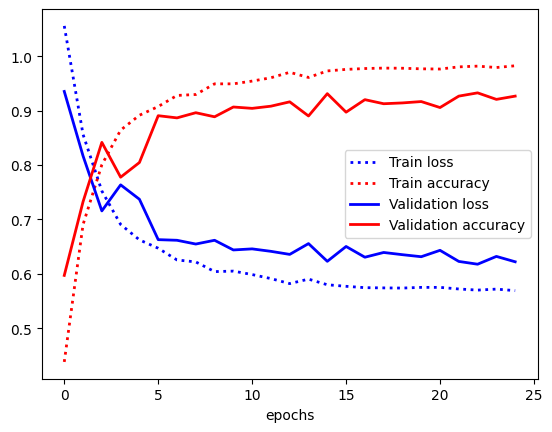

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_loader, val_loader, optimizer, criterion, n_epochs=25, device=device)
test(model, test_loader, device=device)
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

## Task 1: Question 5d

### Different optimizers

In [21]:
# Define new model to prevent ablation study to avoid messing with other results

modelSGD = nn.Sequential(
    
    #block 1

    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    #block 2

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 32, 4, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 3

    sc.Slice(rotation=1, reflection=False),
    sc.SymmetryConv2d(32, 64, 3, stride=1, rotation=1, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 4

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 128, 8, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 5

    Lambda(lambda x: x.view(x.size(0),-1)),
    nn.Linear(2688 , 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes),
    nn.Softmax(dim=1)

)      

modelSGD.to(device)

  4%|▍         | 1/25 [00:22<09:06, 22.78s/it]

Epoch 1/25: Train loss: 1.1068, Train acc: 33.65, Val loss: 1.1050, Val acc: 32.40


  8%|▊         | 2/25 [00:45<08:40, 22.63s/it]

Epoch 2/25: Train loss: 1.0989, Train acc: 35.69, Val loss: 1.1050, Val acc: 32.55


 12%|█▏        | 3/25 [01:08<08:24, 22.93s/it]

Epoch 3/25: Train loss: 1.0929, Train acc: 36.80, Val loss: 1.1046, Val acc: 33.45


 16%|█▌        | 4/25 [01:31<07:58, 22.77s/it]

Epoch 4/25: Train loss: 1.0875, Train acc: 39.41, Val loss: 1.1044, Val acc: 33.55


 20%|██        | 5/25 [01:53<07:31, 22.57s/it]

Epoch 5/25: Train loss: 1.0822, Train acc: 40.56, Val loss: 1.1036, Val acc: 34.90


 24%|██▍       | 6/25 [02:15<07:06, 22.47s/it]

Epoch 6/25: Train loss: 1.0777, Train acc: 42.16, Val loss: 1.1028, Val acc: 35.00


 28%|██▊       | 7/25 [02:38<06:47, 22.64s/it]

Epoch 7/25: Train loss: 1.0726, Train acc: 42.44, Val loss: 1.1018, Val acc: 34.90


 32%|███▏      | 8/25 [03:01<06:24, 22.60s/it]

Epoch 8/25: Train loss: 1.0666, Train acc: 45.17, Val loss: 1.1024, Val acc: 35.65


 36%|███▌      | 9/25 [03:23<06:00, 22.55s/it]

Epoch 9/25: Train loss: 1.0595, Train acc: 46.21, Val loss: 1.1009, Val acc: 35.85


 40%|████      | 10/25 [03:45<05:36, 22.42s/it]

Epoch 10/25: Train loss: 1.0567, Train acc: 46.80, Val loss: 1.1007, Val acc: 34.90


 44%|████▍     | 11/25 [04:07<05:12, 22.35s/it]

Epoch 11/25: Train loss: 1.0510, Train acc: 48.28, Val loss: 1.0990, Val acc: 35.90


 48%|████▊     | 12/25 [04:29<04:49, 22.28s/it]

Epoch 12/25: Train loss: 1.0445, Train acc: 49.96, Val loss: 1.0989, Val acc: 35.90


 52%|█████▏    | 13/25 [04:52<04:26, 22.23s/it]

Epoch 13/25: Train loss: 1.0403, Train acc: 50.41, Val loss: 1.0990, Val acc: 34.75


 56%|█████▌    | 14/25 [05:14<04:04, 22.20s/it]

Epoch 14/25: Train loss: 1.0336, Train acc: 52.40, Val loss: 1.0983, Val acc: 35.20


 60%|██████    | 15/25 [05:36<03:41, 22.16s/it]

Epoch 15/25: Train loss: 1.0307, Train acc: 52.85, Val loss: 1.0984, Val acc: 35.85


 64%|██████▍   | 16/25 [05:58<03:19, 22.14s/it]

Epoch 16/25: Train loss: 1.0260, Train acc: 53.93, Val loss: 1.0966, Val acc: 35.30


 68%|██████▊   | 17/25 [06:20<02:57, 22.13s/it]

Epoch 17/25: Train loss: 1.0196, Train acc: 55.09, Val loss: 1.0956, Val acc: 36.35


 72%|███████▏  | 18/25 [06:42<02:34, 22.11s/it]

Epoch 18/25: Train loss: 1.0117, Train acc: 56.71, Val loss: 1.0952, Val acc: 36.50


 76%|███████▌  | 19/25 [07:04<02:12, 22.10s/it]

Epoch 19/25: Train loss: 1.0105, Train acc: 56.47, Val loss: 1.0924, Val acc: 37.60


 80%|████████  | 20/25 [07:26<01:50, 22.09s/it]

Epoch 20/25: Train loss: 1.0006, Train acc: 58.93, Val loss: 1.0927, Val acc: 36.75


 84%|████████▍ | 21/25 [07:48<01:28, 22.08s/it]

Epoch 21/25: Train loss: 0.9968, Train acc: 58.43, Val loss: 1.0939, Val acc: 36.95


 88%|████████▊ | 22/25 [08:10<01:06, 22.08s/it]

Epoch 22/25: Train loss: 0.9904, Train acc: 59.80, Val loss: 1.0928, Val acc: 36.85


 92%|█████████▏| 23/25 [08:32<00:44, 22.08s/it]

Epoch 23/25: Train loss: 0.9824, Train acc: 61.47, Val loss: 1.0941, Val acc: 36.95


 96%|█████████▌| 24/25 [08:55<00:22, 22.09s/it]

Epoch 24/25: Train loss: 0.9789, Train acc: 62.48, Val loss: 1.0920, Val acc: 38.30


100%|██████████| 25/25 [09:17<00:00, 22.29s/it]

Epoch 25/25: Train loss: 0.9731, Train acc: 62.84, Val loss: 1.0902, Val acc: 37.95


Test loss: 1.0883, Test accuracy: 186/500 (37.20%)
Max val score: 38.30%


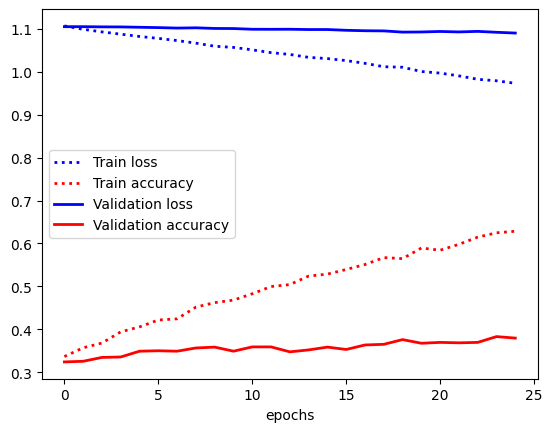

In [22]:
optimizerSGD = torch.optim.SGD(modelSGD.parameters(), lr=0.001)
train_losses, train_accuracies, val_losses, val_accuracies = train(modelSGD.to(device), train_loader, val_loader, optimizerSGD, criterion, n_epochs=25, device=device)
test(modelSGD, test_loader, device=device)
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

In [26]:
# Define new model to prevent ablation study to avoid messing with other results

modelAda = nn.Sequential(
    
    #block 1

    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    #block 2

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 32, 4, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 3

    sc.Slice(rotation=1, reflection=False),
    sc.SymmetryConv2d(32, 64, 3, stride=1, rotation=1, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 4

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 128, 8, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 5

    Lambda(lambda x: x.view(x.size(0),-1)),
    nn.Linear(2688 , 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes),
    nn.Softmax(dim=1)

)      

  4%|▍         | 1/25 [00:23<09:15, 23.15s/it]

Epoch 1/25: Train loss: 1.1078, Train acc: 34.71, Val loss: 1.1032, Val acc: 34.80


  8%|▊         | 2/25 [00:45<08:47, 22.95s/it]

Epoch 2/25: Train loss: 0.9900, Train acc: 59.00, Val loss: 1.1025, Val acc: 34.95


 12%|█▏        | 3/25 [01:08<08:19, 22.69s/it]

Epoch 3/25: Train loss: 0.9173, Train acc: 70.27, Val loss: 1.1039, Val acc: 35.05


 16%|█▌        | 4/25 [01:30<07:52, 22.50s/it]

Epoch 4/25: Train loss: 0.8638, Train acc: 76.25, Val loss: 1.1078, Val acc: 36.10


 20%|██        | 5/25 [01:52<07:29, 22.45s/it]

Epoch 5/25: Train loss: 0.8214, Train acc: 81.33, Val loss: 1.1070, Val acc: 36.00


 24%|██▍       | 6/25 [02:15<07:05, 22.42s/it]

Epoch 6/25: Train loss: 0.7878, Train acc: 84.99, Val loss: 1.1119, Val acc: 35.30


 28%|██▊       | 7/25 [02:37<06:43, 22.39s/it]

Epoch 7/25: Train loss: 0.7595, Train acc: 87.19, Val loss: 1.1112, Val acc: 36.50


 32%|███▏      | 8/25 [02:59<06:20, 22.38s/it]

Epoch 8/25: Train loss: 0.7344, Train acc: 89.37, Val loss: 1.1125, Val acc: 35.90


 36%|███▌      | 9/25 [03:22<05:57, 22.35s/it]

Epoch 9/25: Train loss: 0.7150, Train acc: 91.36, Val loss: 1.1151, Val acc: 35.95


 40%|████      | 10/25 [03:44<05:34, 22.33s/it]

Epoch 10/25: Train loss: 0.6967, Train acc: 92.57, Val loss: 1.1160, Val acc: 35.75


 44%|████▍     | 11/25 [04:06<05:12, 22.31s/it]

Epoch 11/25: Train loss: 0.6833, Train acc: 93.85, Val loss: 1.1192, Val acc: 35.65


 48%|████▊     | 12/25 [04:29<04:50, 22.31s/it]

Epoch 12/25: Train loss: 0.6711, Train acc: 94.36, Val loss: 1.1184, Val acc: 36.30


 52%|█████▏    | 13/25 [04:51<04:27, 22.31s/it]

Epoch 13/25: Train loss: 0.6595, Train acc: 95.29, Val loss: 1.1193, Val acc: 35.95


 56%|█████▌    | 14/25 [05:13<04:05, 22.31s/it]

Epoch 14/25: Train loss: 0.6487, Train acc: 95.84, Val loss: 1.1208, Val acc: 35.50


 60%|██████    | 15/25 [05:36<03:43, 22.31s/it]

Epoch 15/25: Train loss: 0.6423, Train acc: 96.49, Val loss: 1.1212, Val acc: 36.10


 64%|██████▍   | 16/25 [05:58<03:20, 22.31s/it]

Epoch 16/25: Train loss: 0.6346, Train acc: 96.61, Val loss: 1.1232, Val acc: 35.75


 68%|██████▊   | 17/25 [06:20<02:58, 22.30s/it]

Epoch 17/25: Train loss: 0.6277, Train acc: 97.21, Val loss: 1.1244, Val acc: 35.80


 72%|███████▏  | 18/25 [06:42<02:35, 22.28s/it]

Epoch 18/25: Train loss: 0.6244, Train acc: 97.40, Val loss: 1.1240, Val acc: 36.05


 76%|███████▌  | 19/25 [07:05<02:13, 22.27s/it]

Epoch 19/25: Train loss: 0.6179, Train acc: 97.68, Val loss: 1.1236, Val acc: 36.20


 80%|████████  | 20/25 [07:27<01:51, 22.26s/it]

Epoch 20/25: Train loss: 0.6136, Train acc: 97.88, Val loss: 1.1245, Val acc: 35.85


 84%|████████▍ | 21/25 [07:49<01:28, 22.25s/it]

Epoch 21/25: Train loss: 0.6104, Train acc: 97.95, Val loss: 1.1242, Val acc: 36.40


 88%|████████▊ | 22/25 [08:11<01:06, 22.24s/it]

Epoch 22/25: Train loss: 0.6049, Train acc: 98.08, Val loss: 1.1279, Val acc: 35.85


 92%|█████████▏| 23/25 [08:34<00:44, 22.23s/it]

Epoch 23/25: Train loss: 0.6034, Train acc: 98.32, Val loss: 1.1278, Val acc: 35.80


 96%|█████████▌| 24/25 [08:56<00:22, 22.23s/it]

Epoch 24/25: Train loss: 0.5990, Train acc: 98.36, Val loss: 1.1275, Val acc: 35.85


100%|██████████| 25/25 [09:18<00:00, 22.34s/it]

Epoch 25/25: Train loss: 0.5963, Train acc: 98.65, Val loss: 1.1289, Val acc: 35.85


Test loss: 1.1197, Test accuracy: 194/500 (38.80%)
Max val score: 36.50%


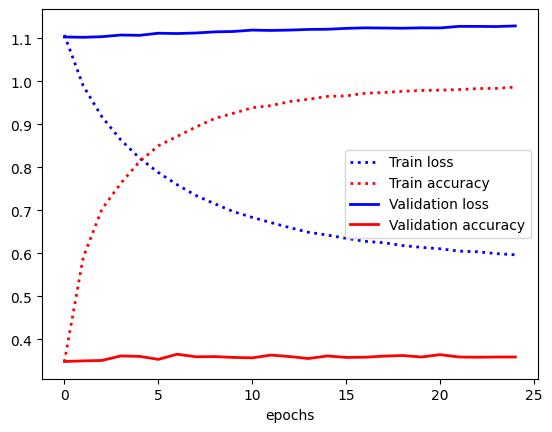

In [27]:
modelAda.to(device)
optimizerAdagrad = torch.optim.Adagrad(modelAda.parameters(), lr=0.001)
train_losses, train_accuracies, val_losses, val_accuracies = train(modelAda, train_loader, val_loader, optimizerAdagrad, criterion, n_epochs=25, device=device)
test(modelAda, test_loader, device=device)
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

In [28]:
# Define new model to prevent ablation study to avoid messing with other results

modelRMS = nn.Sequential(
    
    #block 1

    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    #block 2

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 32, 4, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 3

    sc.Slice(rotation=1, reflection=False),
    sc.SymmetryConv2d(32, 64, 3, stride=1, rotation=1, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 4

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 128, 8, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 5

    Lambda(lambda x: x.view(x.size(0),-1)),
    nn.Linear(2688 , 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes),
    nn.Softmax(dim=1)

)      

  4%|▍         | 1/25 [00:22<08:52, 22.17s/it]

Epoch 1/25: Train loss: 1.0209, Train acc: 49.07, Val loss: 0.9146, Val acc: 62.05


  8%|▊         | 2/25 [00:44<08:30, 22.19s/it]

Epoch 2/25: Train loss: 0.8096, Train acc: 73.61, Val loss: 0.8381, Val acc: 69.20


 12%|█▏        | 3/25 [01:06<08:08, 22.20s/it]

Epoch 3/25: Train loss: 0.7377, Train acc: 81.05, Val loss: 0.7396, Val acc: 80.10


 16%|█▌        | 4/25 [01:28<07:46, 22.21s/it]

Epoch 4/25: Train loss: 0.6847, Train acc: 86.49, Val loss: 0.7477, Val acc: 79.40


 20%|██        | 5/25 [01:51<07:24, 22.22s/it]

Epoch 5/25: Train loss: 0.6653, Train acc: 88.52, Val loss: 0.6854, Val acc: 86.85


 24%|██▍       | 6/25 [02:13<07:02, 22.22s/it]

Epoch 6/25: Train loss: 0.6473, Train acc: 90.43, Val loss: 0.8021, Val acc: 74.30


 28%|██▊       | 7/25 [02:35<06:39, 22.22s/it]

Epoch 7/25: Train loss: 0.6282, Train acc: 92.32, Val loss: 0.6668, Val acc: 88.05


 32%|███▏      | 8/25 [02:57<06:17, 22.22s/it]

Epoch 8/25: Train loss: 0.6211, Train acc: 93.00, Val loss: 0.6697, Val acc: 87.90


 36%|███▌      | 9/25 [03:19<05:55, 22.21s/it]

Epoch 9/25: Train loss: 0.6138, Train acc: 93.73, Val loss: 0.6664, Val acc: 88.15


 40%|████      | 10/25 [03:42<05:32, 22.20s/it]

Epoch 10/25: Train loss: 0.6004, Train acc: 95.03, Val loss: 0.6694, Val acc: 87.60


 44%|████▍     | 11/25 [04:04<05:10, 22.20s/it]

Epoch 11/25: Train loss: 0.5990, Train acc: 95.20, Val loss: 0.6705, Val acc: 87.55


 48%|████▊     | 12/25 [04:26<04:48, 22.19s/it]

Epoch 12/25: Train loss: 0.5990, Train acc: 95.25, Val loss: 0.6715, Val acc: 87.35


 52%|█████▏    | 13/25 [04:48<04:26, 22.19s/it]

Epoch 13/25: Train loss: 0.5906, Train acc: 96.07, Val loss: 0.6350, Val acc: 90.90


 56%|█████▌    | 14/25 [05:10<04:04, 22.19s/it]

Epoch 14/25: Train loss: 0.5904, Train acc: 95.95, Val loss: 0.6624, Val acc: 88.65


 60%|██████    | 15/25 [05:33<03:42, 22.20s/it]

Epoch 15/25: Train loss: 0.5897, Train acc: 96.07, Val loss: 0.6506, Val acc: 89.75


 64%|██████▍   | 16/25 [05:55<03:19, 22.21s/it]

Epoch 16/25: Train loss: 0.5828, Train acc: 96.89, Val loss: 0.6544, Val acc: 89.55


 68%|██████▊   | 17/25 [06:17<02:57, 22.21s/it]

Epoch 17/25: Train loss: 0.5808, Train acc: 97.01, Val loss: 0.6445, Val acc: 90.45


 72%|███████▏  | 18/25 [06:39<02:35, 22.22s/it]

Epoch 18/25: Train loss: 0.5783, Train acc: 97.24, Val loss: 0.6338, Val acc: 91.45


 76%|███████▌  | 19/25 [07:01<02:13, 22.21s/it]

Epoch 19/25: Train loss: 0.5783, Train acc: 97.35, Val loss: 0.6422, Val acc: 90.60


 80%|████████  | 20/25 [07:24<01:51, 22.21s/it]

Epoch 20/25: Train loss: 0.5751, Train acc: 97.52, Val loss: 0.6361, Val acc: 91.15


 84%|████████▍ | 21/25 [07:46<01:28, 22.21s/it]

Epoch 21/25: Train loss: 0.5786, Train acc: 97.28, Val loss: 0.6415, Val acc: 90.60


 88%|████████▊ | 22/25 [08:08<01:06, 22.21s/it]

Epoch 22/25: Train loss: 0.5743, Train acc: 97.69, Val loss: 0.6567, Val acc: 89.10


 92%|█████████▏| 23/25 [08:30<00:44, 22.21s/it]

Epoch 23/25: Train loss: 0.5704, Train acc: 98.08, Val loss: 0.6362, Val acc: 91.15


 96%|█████████▌| 24/25 [08:52<00:22, 22.21s/it]

Epoch 24/25: Train loss: 0.5692, Train acc: 98.25, Val loss: 0.6264, Val acc: 91.85


100%|██████████| 25/25 [09:15<00:00, 22.21s/it]

Epoch 25/25: Train loss: 0.5709, Train acc: 98.05, Val loss: 0.6688, Val acc: 87.85


Test loss: 0.6611, Test accuracy: 444/500 (88.80%)
Max val score: 91.85%


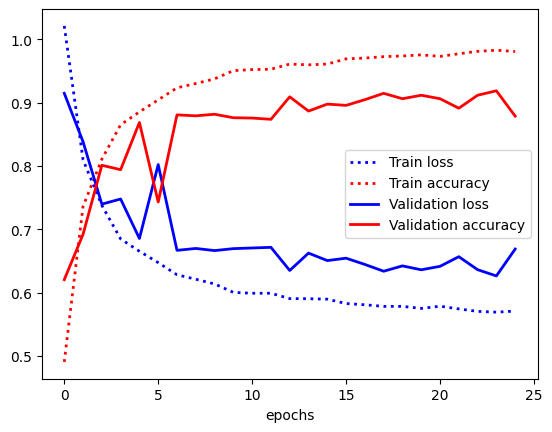

In [29]:
modelRMS.to(device)
optimizerRMS = torch.optim.RMSprop(modelRMS.parameters(), lr=0.001)
train_losses, train_accuracies, val_losses, val_accuracies = train(modelRMS, train_loader, val_loader, optimizerRMS, criterion, n_epochs=25, device=device)
test(modelRMS, test_loader, device=device)
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

### Changing train size

In [31]:
X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

In [32]:
# Define new model to prevent ablation study to avoid messing with other results

modelLess = nn.Sequential(
    
    #block 1

    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    #block 2

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 32, 4, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 3

    sc.Slice(rotation=1, reflection=False),
    sc.SymmetryConv2d(32, 64, 3, stride=1, rotation=1, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 4

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 128, 8, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 5

    Lambda(lambda x: x.view(x.size(0),-1)),
    nn.Linear(2688 , 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes),
    nn.Softmax(dim=1)

)      

  4%|▍         | 1/25 [00:16<06:39, 16.63s/it]

Epoch 1/25: Train loss: 1.1039, Train acc: 37.32, Val loss: 1.0498, Val acc: 46.56


  8%|▊         | 2/25 [00:33<06:24, 16.73s/it]

Epoch 2/25: Train loss: 0.9437, Train acc: 58.68, Val loss: 0.9367, Val acc: 58.47


 12%|█▏        | 3/25 [00:50<06:10, 16.85s/it]

Epoch 3/25: Train loss: 0.8311, Train acc: 71.38, Val loss: 0.8523, Val acc: 68.51


 16%|█▌        | 4/25 [01:07<05:51, 16.76s/it]

Epoch 4/25: Train loss: 0.7535, Train acc: 79.86, Val loss: 0.8314, Val acc: 70.96


 20%|██        | 5/25 [01:23<05:33, 16.69s/it]

Epoch 5/25: Train loss: 0.7065, Train acc: 84.76, Val loss: 0.8041, Val acc: 73.58


 24%|██▍       | 6/25 [01:40<05:16, 16.66s/it]

Epoch 6/25: Train loss: 0.6677, Train acc: 89.14, Val loss: 0.7938, Val acc: 74.89


 28%|██▊       | 7/25 [01:56<04:59, 16.66s/it]

Epoch 7/25: Train loss: 0.6477, Train acc: 90.60, Val loss: 0.7513, Val acc: 79.62


 32%|███▏      | 8/25 [02:13<04:43, 16.67s/it]

Epoch 8/25: Train loss: 0.6394, Train acc: 91.22, Val loss: 0.7824, Val acc: 76.07


 36%|███▌      | 9/25 [02:30<04:26, 16.67s/it]

Epoch 9/25: Train loss: 0.6230, Train acc: 92.82, Val loss: 0.7838, Val acc: 75.44


 40%|████      | 10/25 [02:46<04:09, 16.65s/it]

Epoch 10/25: Train loss: 0.6101, Train acc: 94.44, Val loss: 0.7671, Val acc: 77.67


 44%|████▍     | 11/25 [03:03<03:52, 16.64s/it]

Epoch 11/25: Train loss: 0.6091, Train acc: 94.22, Val loss: 0.7567, Val acc: 78.53


 48%|████▊     | 12/25 [03:20<03:36, 16.64s/it]

Epoch 12/25: Train loss: 0.5966, Train acc: 95.62, Val loss: 0.7351, Val acc: 81.04


 52%|█████▏    | 13/25 [03:36<03:19, 16.65s/it]

Epoch 13/25: Train loss: 0.5917, Train acc: 96.12, Val loss: 0.7435, Val acc: 80.13


 56%|█████▌    | 14/25 [03:53<03:03, 16.64s/it]

Epoch 14/25: Train loss: 0.5864, Train acc: 96.78, Val loss: 0.7281, Val acc: 81.31


 60%|██████    | 15/25 [04:10<02:46, 16.65s/it]

Epoch 15/25: Train loss: 0.5936, Train acc: 95.82, Val loss: 0.7488, Val acc: 79.42


 64%|██████▍   | 16/25 [04:26<02:29, 16.65s/it]

Epoch 16/25: Train loss: 0.5840, Train acc: 96.94, Val loss: 0.7387, Val acc: 80.51


 68%|██████▊   | 17/25 [04:43<02:13, 16.66s/it]

Epoch 17/25: Train loss: 0.5777, Train acc: 97.56, Val loss: 0.7367, Val acc: 80.98


 72%|███████▏  | 18/25 [05:00<01:56, 16.66s/it]

Epoch 18/25: Train loss: 0.5766, Train acc: 97.60, Val loss: 0.7566, Val acc: 78.62


 76%|███████▌  | 19/25 [05:16<01:39, 16.66s/it]

Epoch 19/25: Train loss: 0.5806, Train acc: 97.12, Val loss: 0.7539, Val acc: 79.02


 80%|████████  | 20/25 [05:33<01:23, 16.65s/it]

Epoch 20/25: Train loss: 0.5837, Train acc: 96.72, Val loss: 0.7369, Val acc: 80.84


 84%|████████▍ | 21/25 [05:50<01:06, 16.66s/it]

Epoch 21/25: Train loss: 0.5797, Train acc: 97.30, Val loss: 0.7283, Val acc: 81.56


 88%|████████▊ | 22/25 [06:06<00:49, 16.66s/it]

Epoch 22/25: Train loss: 0.5774, Train acc: 97.48, Val loss: 0.7420, Val acc: 80.33


 92%|█████████▏| 23/25 [06:23<00:33, 16.65s/it]

Epoch 23/25: Train loss: 0.5736, Train acc: 97.78, Val loss: 0.7230, Val acc: 82.04


 96%|█████████▌| 24/25 [06:39<00:16, 16.65s/it]

Epoch 24/25: Train loss: 0.5706, Train acc: 98.14, Val loss: 0.7226, Val acc: 82.69


100%|██████████| 25/25 [06:56<00:00, 16.66s/it]

Epoch 25/25: Train loss: 0.5690, Train acc: 98.26, Val loss: 0.7388, Val acc: 80.73


Test loss: 0.7697, Test accuracy: 386/500 (77.20%)
Max val score: 82.69%


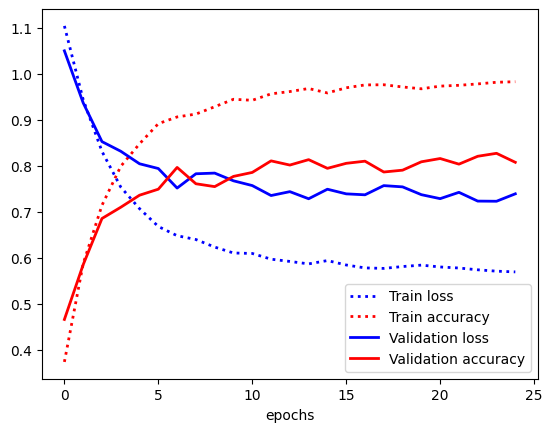

In [33]:
# Less training
X_train = X[:5000]
X_val = X[5000:9500]
X_test = X[9500:]
y_train = y[:5000]
y_val = y[5000:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

modelLess.to(device)
optimizer = torch.optim.Adam(modelLess.parameters(), lr=0.001)
train_losses, train_accuracies, val_losses, val_accuracies = train(modelLess, train_loader, val_loader, optimizer, criterion, n_epochs=25, device=device)
test(modelLess, test_loader, device=device)
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

In [34]:
# Define new model to prevent ablation study to avoid messing with other results

modelMore = nn.Sequential(
    
    #block 1

    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    #block 2

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 32, 4, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 3

    sc.Slice(rotation=1, reflection=False),
    sc.SymmetryConv2d(32, 64, 3, stride=1, rotation=1, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 4

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 128, 8, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 5

    Lambda(lambda x: x.view(x.size(0),-1)),
    nn.Linear(2688 , 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes),
    nn.Softmax(dim=1)

) 

In [ ]:
# More training
X_train = X[:8500]
X_val = X[8500:9500]
X_test = X[9500:]
y_train = y[:8500]
y_val = y[8500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

modelMore.to(device)
optimizer = torch.optim.Adam(modelMore.parameters(), lr=0.001)
train_losses, train_accuracies, val_losses, val_accuracies = train(modelMore, train_loader, val_loader, optimizer, criterion, n_epochs=25, device=device)
test(modelMore, test_loader, device=device)
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

  4%|▍         | 1/25 [00:24<09:50, 24.62s/it]

Epoch 1/25: Train loss: 1.0467, Train acc: 44.99, Val loss: 0.8895, Val acc: 65.90


  8%|▊         | 2/25 [00:49<09:26, 24.63s/it]

Epoch 2/25: Train loss: 0.8190, Train acc: 72.40, Val loss: 0.7603, Val acc: 79.40


 12%|█▏        | 3/25 [01:13<09:02, 24.64s/it]

Epoch 3/25: Train loss: 0.7249, Train acc: 82.72, Val loss: 0.7148, Val acc: 83.50


 16%|█▌        | 4/25 [01:38<08:37, 24.65s/it]

Epoch 4/25: Train loss: 0.6700, Train acc: 88.26, Val loss: 0.6703, Val acc: 88.70


 20%|██        | 5/25 [02:03<08:13, 24.65s/it]

Epoch 5/25: Train loss: 0.6404, Train acc: 91.32, Val loss: 0.6512, Val acc: 89.60


 24%|██▍       | 6/25 [02:27<07:48, 24.65s/it]

Epoch 6/25: Train loss: 0.6339, Train acc: 91.85, Val loss: 0.6769, Val acc: 87.10


 28%|██▊       | 7/25 [02:52<07:23, 24.64s/it]

Epoch 7/25: Train loss: 0.6126, Train acc: 94.12, Val loss: 0.6350, Val acc: 92.20


 32%|███▏      | 8/25 [03:17<06:58, 24.63s/it]

Epoch 8/25: Train loss: 0.6041, Train acc: 94.85, Val loss: 0.6375, Val acc: 91.00


 36%|███▌      | 9/25 [03:41<06:33, 24.62s/it]

Epoch 9/25: Train loss: 0.5951, Train acc: 95.68, Val loss: 0.6408, Val acc: 91.00


 40%|████      | 10/25 [04:06<06:09, 24.62s/it]

Epoch 10/25: Train loss: 0.5901, Train acc: 96.22, Val loss: 0.6322, Val acc: 91.90


 44%|████▍     | 11/25 [04:30<05:44, 24.61s/it]

Epoch 11/25: Train loss: 0.5932, Train acc: 95.95, Val loss: 0.6431, Val acc: 90.40


 48%|████▊     | 12/25 [04:55<05:19, 24.61s/it]

Epoch 12/25: Train loss: 0.5860, Train acc: 96.67, Val loss: 0.6165, Val acc: 93.30


 52%|█████▏    | 13/25 [05:20<04:55, 24.60s/it]

Epoch 13/25: Train loss: 0.5796, Train acc: 97.26, Val loss: 0.6296, Val acc: 91.90


 56%|█████▌    | 14/25 [05:44<04:30, 24.60s/it]

Epoch 14/25: Train loss: 0.5850, Train acc: 96.76, Val loss: 0.6165, Val acc: 93.20


 60%|██████    | 15/25 [06:09<04:05, 24.60s/it]

Epoch 15/25: Train loss: 0.5778, Train acc: 97.39, Val loss: 0.6176, Val acc: 93.80


 64%|██████▍   | 16/25 [06:33<03:41, 24.60s/it]

Epoch 16/25: Train loss: 0.5786, Train acc: 97.32, Val loss: 0.6231, Val acc: 93.10


 68%|██████▊   | 17/25 [06:58<03:16, 24.60s/it]

Epoch 17/25: Train loss: 0.5721, Train acc: 97.95, Val loss: 0.6206, Val acc: 93.10


 72%|███████▏  | 18/25 [07:23<02:52, 24.60s/it]

Epoch 18/25: Train loss: 0.5755, Train acc: 97.66, Val loss: 0.6207, Val acc: 92.40


 76%|███████▌  | 19/25 [07:47<02:27, 24.60s/it]

Epoch 19/25: Train loss: 0.5703, Train acc: 98.11, Val loss: 0.6196, Val acc: 93.40


 80%|████████  | 20/25 [08:12<02:03, 24.60s/it]

Epoch 20/25: Train loss: 0.5749, Train acc: 97.61, Val loss: 0.6206, Val acc: 93.20


### Experimenting with more layers or less layers

In [ ]:
# Less layers
modelLessLayers = nn.Sequential(
    
    #block 1
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    # nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    # nn.BatchNorm2d(16),
    # nn.ReLU(),
    # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    # nn.BatchNorm2d(32),
    # nn.ReLU(),

    #block 2
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 32, 4, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 3
    sc.Slice(rotation=1, reflection=False),
    sc.SymmetryConv2d(32, 64, 3, stride=1, rotation=1, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 4
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 128, 8, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 5
    Lambda(lambda x: x.view(x.size(0),-1)),
    nn.Linear(2688, num_classes),           # Changed
    # nn.BatchNorm1d(1024),                 # Removed
    # nn.ReLU(),                            # Removed
    # nn.Dropout(0.5),                      # Removed
    # nn.Linear(1024, num_classes),         # Removed
    nn.Softmax(dim=1)
)      

modelLessLayers.to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train(modelLessLayers, train_loader, val_loader, optimizer, criterion, n_epochs=25, device=device)
test(modelLessLayers, test_loader, device=device)
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
# More layers
modelMoreLayers = nn.Sequential(
    
    #block 1
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),   # Added
    nn.BatchNorm2d(32),                                                     # Added
    nn.ReLU(),                                                              # Added

    #block 2

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 32, 4, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 3

    sc.Slice(rotation=1, reflection=False),
    sc.SymmetryConv2d(32, 64, 3, stride=1, rotation=1, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 4

    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 128, 8, stride=1, rotation=4, reflection=False),
    sc.SymmetryPool(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),

    #block 5

    Lambda(lambda x: x.view(x.size(0),-1)),
    nn.Linear(2688 , 2048),                                               # Changed
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048 , 1024),                                               # Added
    nn.BatchNorm1d(1024),                                                 # Added
    nn.ReLU(),                                                            # Added
    nn.Dropout(0.5),                                                      # Added
    nn.Linear(1024 , 256),                                                # Added
    nn.BatchNorm1d(256),                                                  # Added
    nn.ReLU(),                                                            # Added
    nn.Dropout(0.5),                                                      # Added
    nn.Linear(256 , 64),                                                  # Added
    nn.BatchNorm1d(64),                                                   # Added
    nn.ReLU(),                                                            # Added
    nn.Dropout(0.5),                                                      # Added
    nn.Linear(64, num_classes),                                           # Added
    nn.Softmax(dim=1)
)      

modelMoreLayers.to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train(modelMoreLayers, train_loader, val_loader, optimizer, criterion, n_epochs=25, device=device)
test(modelMoreLayers, test_loader, device=device)
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Task 2: Carpet Matching 

In [12]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [13]:
# function to determine performance of model
def query_performance(net, queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().cuda()
        t = targets[i].float().cuda()

        with torch.no_grad():
            
            
            ### MODIFY IF NECESSARY ###
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [14]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super(EmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            
        #block 1
            
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        #block 2

        sc.Slice(rotation=4, reflection=False),
        sc.SymmetryConv2d(32, 32, 4, stride=1, rotation=4, reflection=False),
        sc.SymmetryPool(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #block 3

        sc.Slice(rotation=1, reflection=False),
        sc.SymmetryConv2d(32, 64, 3, stride=1, rotation=1, reflection=False),
        sc.SymmetryPool(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #block 4

        sc.Slice(rotation=4, reflection=False),
        sc.SymmetryConv2d(64, 128, 8, stride=1, rotation=4, reflection=False),
        sc.SymmetryPool(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #block 5
        
        Lambda(lambda x: x.view(x.size(0),-1)),
        nn.Linear(2688 , 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 200),
        nn.Softmax(dim=1)
        )

        #self.last_layer = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        #x = self.last_layer(x)
        return x
    
    def get_embedding(self, x):
        return self.forward(x)

In [15]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [16]:
from itertools import combinations

class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


In [17]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [18]:
from itertools import combinations

class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()
  
        self.margin = margin
  
   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):
        
        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None
    

    def get_triplets(self, embeddings, labels):
        
        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            
            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                
                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)
        
        return torch.LongTensor(triplets)

In [19]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

            
        anchor_idx= triplets[:, 0]  
        positive_idx= triplets[:, 1]  
        negative_idx= triplets[:, 2]  
            
            
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu((ap_distances - an_distances)/an_distances.mean() + self.margin)

        return losses.mean()

In [20]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            train_losses=[]
            for batch in self.training_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)
                
            # print the results
            print(f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}', end=' ')
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

In [21]:
train_dataset = TensorDataset(torch.from_numpy(X.astype(np.float32)[:12000]), torch.from_numpy(y.astype(np.float32)[:12000]))
test_dataset = TensorDataset(torch.from_numpy(X.astype(np.float32)[12000:]), torch.from_numpy(y.astype(np.float32)[12000:]))

train_batch_sampler = BalancedBatchSampler(y.astype(np.float32)[:12000], n_classes=20, n_samples=20)
test_batch_sampler = BalancedBatchSampler(y.astype(np.float32)[12000:], n_classes=20, n_samples=20)

triplets_train_loader = DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_test_loader = DataLoader(test_dataset, batch_sampler=test_batch_sampler)

In [27]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
    
# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  RandomTripletSelector())

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_test_loader,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|█         | 1/10 [00:28<04:15, 28.36s/it]

EPOCH: 01/10 LOSS: 1.0005 VAL-LOSS: 1.0536


 20%|██        | 2/10 [00:56<03:47, 28.48s/it]

EPOCH: 02/10 LOSS: 0.9982 VAL-LOSS: 0.9967


 30%|███       | 3/10 [01:25<03:18, 28.42s/it]

EPOCH: 03/10 LOSS: 0.9992 VAL-LOSS: 0.9970


 40%|████      | 4/10 [01:53<02:50, 28.48s/it]

EPOCH: 04/10 LOSS: 1.0011 VAL-LOSS: 0.9994


 50%|█████     | 5/10 [02:22<02:22, 28.46s/it]

EPOCH: 05/10 LOSS: 0.9992 VAL-LOSS: 0.9986


 60%|██████    | 6/10 [02:50<01:53, 28.38s/it]

EPOCH: 06/10 LOSS: 1.0008 VAL-LOSS: 1.0018


 70%|███████   | 7/10 [03:18<01:25, 28.40s/it]

EPOCH: 07/10 LOSS: 0.9992 VAL-LOSS: 0.9979


 80%|████████  | 8/10 [03:47<00:56, 28.37s/it]

EPOCH: 08/10 LOSS: 1.0002 VAL-LOSS: 1.0004


 90%|█████████ | 9/10 [04:15<00:28, 28.36s/it]

EPOCH: 09/10 LOSS: 1.0003 VAL-LOSS: 1.0023


100%|██████████| 10/10 [04:43<00:00, 28.40s/it]

EPOCH: 10/10 LOSS: 0.9992 VAL-LOSS: 0.9980


In [28]:
q = torch.from_numpy(queries).float().cuda()
t = torch.from_numpy(targets).float().cuda()
g = torch.from_numpy(gt).float().cuda()

print(query_performance(model, q, t, g, 1))

73.33333333333333


In [29]:
def extract_embeddings(dataloader, model):
    
    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 200))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(triplets_train_loader, model)
val_embeddings, val_labels = extract_embeddings(triplets_test_loader, model)

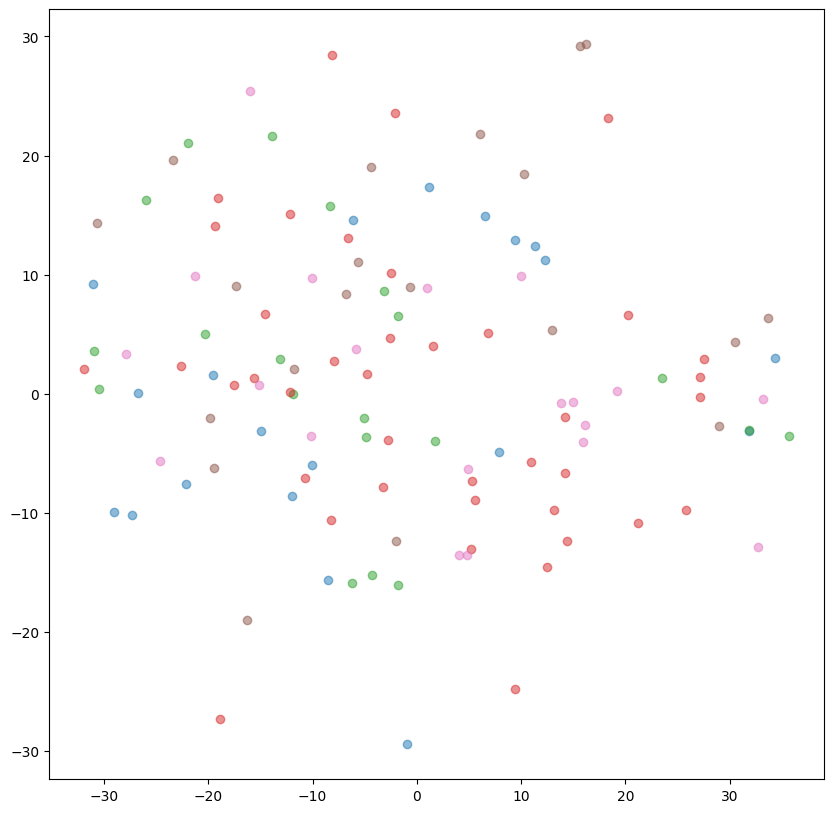

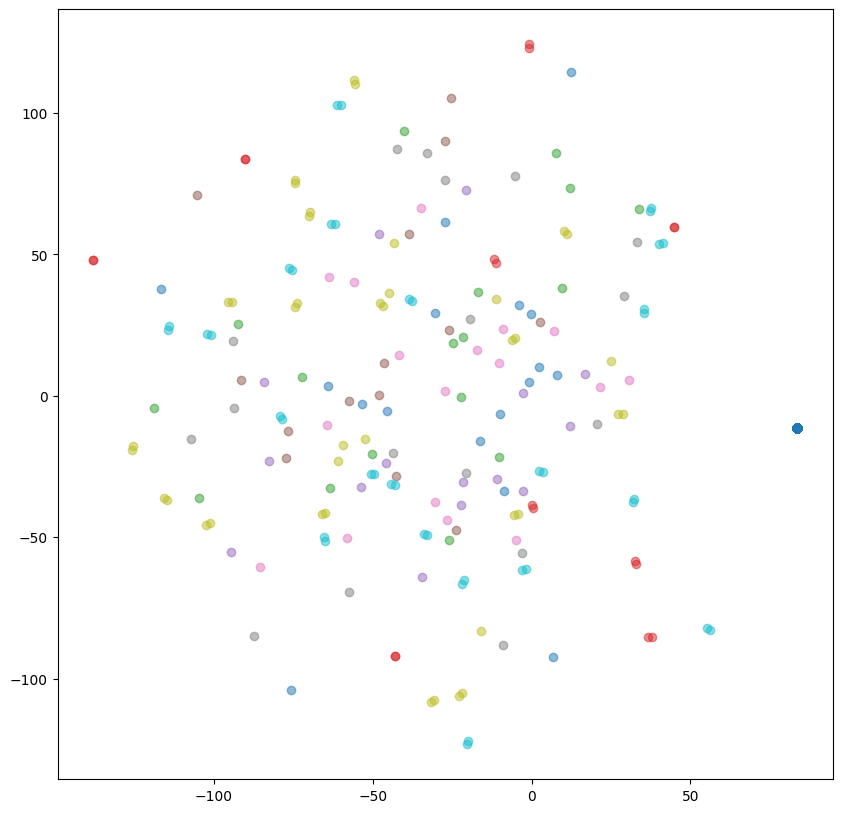

In [30]:
from sklearn.manifold import TSNE
def plot_tsne_embeddings(embeddings, targets, xlim=None, ylim=None):
    
    
    # The first 3000 embeddings and targets
    embeddings= embeddings[:3000]
    targets= targets[:3000]

    # Using Tsne to for dimension reduction 
    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    # plt.legend(classes)

plot_tsne_embeddings(train_embeddings, train_labels)
plot_tsne_embeddings(val_embeddings, val_labels)